# Intro

**Seminar by @Elad_Benjo**

In this notebook I will attempt to develop a new model for nowcsating of the Israeli GDP.

# Data Import and Preprocessing

In this section, I am going to import our files, convert them to CSV files, and then start researching them. At this part of the preprocessing I will look for missing data, corrupted records or broken files, and also pay attention to frequency and the difference of frequencies between the files, to get a better understaning of what we have. But mostly it is cleaning and filling.

#### Access Drive

In [16]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import sys
sys.path.append('/content/drive/MyDrive/gdp_nowcasting_seminar/src')
import preprocessing
import util

In [ ]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/GDP_Nowcasting_Seminar/src']


In [ ]:
import importlib
importlib.reload(util)

<module 'util' from '/content/drive/MyDrive/gdp_nowcasting_seminar/src/util.py'>

In [18]:
data_frames = util.load_all_pickles_from_drive()

Loaded macro_monthly_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/macro_monthly_df.pkl
Loaded macro_quarterly_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/macro_quarterly_df.pkl
Loaded indirect_tax_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/indirect_tax_df.pkl
Loaded direct_tax_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/direct_tax_df.pkl


#### Import Files and Convert

*peek of the macro-economic data:*

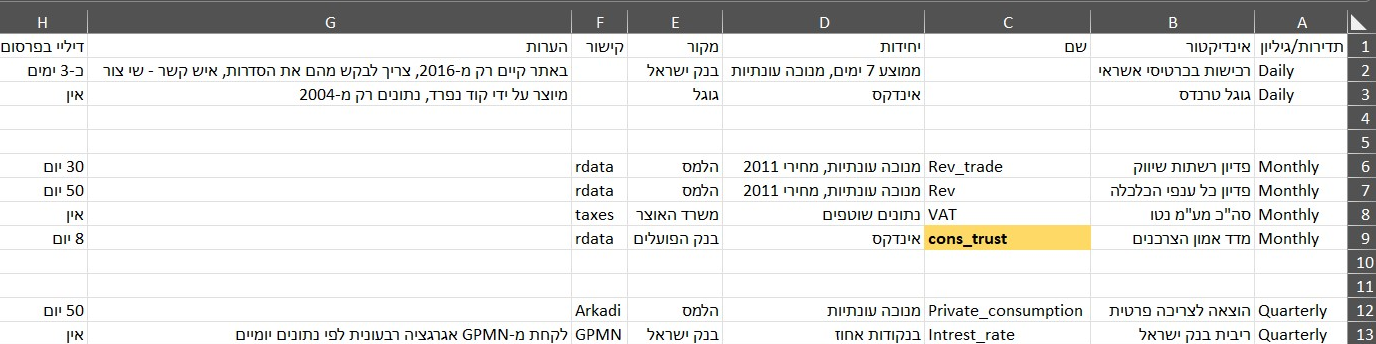

Manual EXCEL labor done prior to this part:


1.   re-formatting some tables and removing multiple headlines and or descriptive lines
2.   Translating Hebrew to English
3. Removing unneccesary sheets (pasted above)



Now let's move on, load our data and briefly examine it.

#### Load CSV's

In [ ]:
import os
import pandas as pd

folder_path = '/content/drive/MyDrive/GDP_Nowcasting_Seminar/Data/formatted_CSVs'
data_frames = {}

# load each file into a seperate df with respectful names
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df_name = filename.replace('.csv', '_df')
        try:
            data_frames[df_name] = pd.read_csv(file_path)
            print(f"Loaded {filename} into {df_name}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")


Loaded macro_monthly.csv into macro_monthly_df
Loaded indirect_tax.csv into indirect_tax_df
Loaded macro_quarterly.csv into macro_quarterly_df
Loaded direct_tax.csv into direct_tax_df


we'll print an 'info' and 'describe' for each file.  

info will tell us how many records there are, how many missing values, and their type;  
describe will give us a short peek over statistical information for each column.

In [ ]:
preprocessing.info_and_describe(data_frames)


--- Info for macro_monthly_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 49 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Date                                                     364 non-null    object 
 1   Month                                                    363 non-null    float64
 2   Quarter                                                  363 non-null    float64
 3   Year                                                     363 non-null    float64
 4   CPI                                                      363 non-null    float64
 5   dir                                                      351 non-null    object 
 6   indir                                                    351 non-null    object 
 7   VAT                                                      351 non-null    object 


plenty of missing values, non-matching record counts between different tables, no uniform date formats, data types don't match the acutal records and some extra empty columns to remove.  
we will work top-down through each df to update and fix it.

start with removing any "unnamed" column

In [ ]:
for df_name, df in data_frames.items():
    cols_to_drop = [col for col in df.columns if 'Unnamed:' in col]
    data_frames[df_name] = df.drop(columns=cols_to_drop)
    print(f"Removed {cols_to_drop} from {df_name}")

Removed ['Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48'] from macro_monthly_df
Removed [] from indirect_tax_df
Removed ['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'] from macro_quarterly_df
Removed [] from direct_tax_df


We removed some 'garbage' columns, next I want to do is to address the 'Date' issues and give it a uniform format across all tables.

#### Date formatting

##### tax dfs

In [ ]:
print(data_frames['direct_tax_df']['month_year'])
print(data_frames['indirect_tax_df']['month_year'])

0      Jan-96
1      Feb-96
2      Mar-96
3      Apr-96
4      May-96
        ...  
347    24-Dec
348    25-Jan
349    25-Feb
350    25-Mar
351    25-Apr
Name: month_year, Length: 352, dtype: object
0      Jan-96
1      Feb-96
2      Mar-96
3      Apr-96
4      May-96
        ...  
347    24-Dec
348    25-Jan
349    25-Feb
350    25-Mar
351    25-Apr
Name: month_year, Length: 352, dtype: object


Currently it's in a textual kind of type to describe the time, I will update it to be a mm/dd/yyyy format and convert it to pandas datetime

In [ ]:
data_frames['direct_tax_df']["month_year_clean"] = preprocessing.clean_month_year(data_frames['direct_tax_df']["month_year"])

In [ ]:
print(data_frames['direct_tax_df']['month_year_clean'])

0     1996-01-01
1     1996-02-01
2     1996-03-01
3     1996-04-01
4     1996-05-01
         ...    
347   2025-12-01
348   2025-01-01
349   2025-02-01
350   2025-03-01
351   2025-04-01
Name: month_year_clean, Length: 352, dtype: datetime64[ns]


In [ ]:
data_frames['indirect_tax_df']["month_year_clean"] = preprocessing.clean_month_year(data_frames['indirect_tax_df']["month_year"])

In [ ]:
print(data_frames['indirect_tax_df']['month_year_clean'])

0     1996-01-01
1     1996-02-01
2     1996-03-01
3     1996-04-01
4     1996-05-01
         ...    
347   2025-12-01
348   2025-01-01
349   2025-02-01
350   2025-03-01
351   2025-04-01
Name: month_year_clean, Length: 352, dtype: datetime64[ns]


##### macro_quarterly_df

In [ ]:
data_frames['macro_quarterly_df']['Date'] = data_frames['macro_quarterly_df']['Date'] + pd.DateOffset(months=3)

##### Debried for al dfs

In [ ]:
for name, df in data_frames.items():
    print(f"\n=== DataFrame: {name} ===")
    preprocessing.print_date_range(df)


=== DataFrame: macro_monthly_df ===
Earliest date: 1995-01-01 00:00:00
Latest date: 2025-04-01 00:00:00

=== DataFrame: macro_quarterly_df ===
Earliest date: 1995-04-01 00:00:00
Latest date: 2025-04-01 00:00:00

=== DataFrame: indirect_tax_df ===
Earliest date: 1996-01-01 00:00:00
Latest date: 2025-12-01 00:00:00

=== DataFrame: direct_tax_df ===
Earliest date: 1996-01-01 00:00:00
Latest date: 2025-12-01 00:00:00


### Data Types Adjustment

some data types are not represnting correctly the data they hold, most of the columns are from type 'object' but we are going to need them as 'float'.  
We will remove additional 'text' from the numnbers and convert to float.

#### macro_montly_df

In [ ]:
data_frames['macro_monthly_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 39 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Date                                                     364 non-null    object 
 1   Month                                                    363 non-null    float64
 2   Quarter                                                  363 non-null    float64
 3   Year                                                     363 non-null    float64
 4   CPI                                                      363 non-null    float64
 5   dir                                                      351 non-null    object 
 6   indir                                                    351 non-null    object 
 7   VAT                                                      351 non-null    object 
 8   imp                           

In [ ]:
data_frames['macro_monthly_df'] = preprocessing.clean_percentage_columns(data_frames['macro_monthly_df'])

In [ ]:
data_frames['macro_monthly_df'] = preprocessing.convert_object_columns_to_float(data_frames['macro_monthly_df'])

In [ ]:
data_frames['macro_monthly_df']['Date'] = pd.to_datetime(data_frames['macro_monthly_df']['Date'])

In [ ]:
data_frames['macro_monthly_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 39 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date                                                     364 non-null    datetime64[ns]
 1   Month                                                    363 non-null    float64       
 2   Quarter                                                  363 non-null    float64       
 3   Year                                                     363 non-null    float64       
 4   CPI                                                      363 non-null    float64       
 5   dir                                                      351 non-null    float64       
 6   indir                                                    351 non-null    float64       
 7   VAT                                                  

#### macro_quarterly_df

In [ ]:
data_frames['macro_quarterly_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          121 non-null    object 
 1   Quarter       121 non-null    float64
 2   Year          121 non-null    float64
 3   GDP           120 non-null    object 
 4   Intrest_rate  117 non-null    float64
 5   CPI           121 non-null    float64
 6   C             120 non-null    object 
 7   G             120 non-null    object 
 8   I             120 non-null    float64
 9   EX            120 non-null    float64
 10  IM            120 non-null    float64
dtypes: float64(7), object(4)
memory usage: 21.4+ KB


In [ ]:
data_frames['macro_quarterly_df'] = preprocessing.clean_percentage_columns(data_frames['macro_quarterly_df'])
data_frames['macro_quarterly_df'] = preprocessing.convert_object_columns_to_float(data_frames['macro_quarterly_df'])

/tmp/ipython-input-13-1053055694.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_frames['macro_quarterly_df']['Date'] = pd.to_datetime(data_frames['macro_quarterly_df']['Date'])


In [ ]:
data_frames['macro_quarterly_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          121 non-null    datetime64[ns]
 1   Quarter       121 non-null    float64       
 2   Year          121 non-null    float64       
 3   GDP           120 non-null    float64       
 4   Intrest_rate  117 non-null    float64       
 5   CPI           121 non-null    float64       
 6   C             120 non-null    float64       
 7   G             120 non-null    float64       
 8   I             120 non-null    float64       
 9   EX            120 non-null    float64       
 10  IM            120 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 21.4 KB


#### direct_tax_df

In [ ]:
data_frames['direct_tax_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 28 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   month_year                                                                        352 non-null    object        
 1   Total Gross Income Tax Division                                                   352 non-null    object        
 2    Total refunds from the Income Tax Department                                     352 non-null    object        
 3   Total Income Tax Division Net                                                     352 non-null    object        
 4   Income tax for self-employed individuals and companies (advances and deductions)  352 non-null    object        
 5   Deductions and the capital market                               

I went back after spotting missing values in 'month_year_clean' and adjusted the relevant function...

In [ ]:
data_frames['direct_tax_df'] = preprocessing.clean_percentage_columns(data_frames['direct_tax_df'])
data_frames['direct_tax_df'] = preprocessing.convert_object_columns_to_float(data_frames['direct_tax_df'])

Could not convert column 'month_year' to float: could not convert string to float: 'Jan-96'


In [ ]:
data_frames['direct_tax_df'].drop(columns=['month_year'], inplace=True)

In [ ]:
data_frames['direct_tax_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 27 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   Total Gross Income Tax Division                                                   352 non-null    float64       
 1    Total refunds from the Income Tax Department                                     352 non-null    float64       
 2   Total Income Tax Division Net                                                     352 non-null    float64       
 3   Income tax for self-employed individuals and companies (advances and deductions)  352 non-null    float64       
 4   Deductions and the capital market                                                 352 non-null    float64       
 5   Real estate taxation                                            

#### indirect_tax_df

In [ ]:
data_frames['indirect_tax_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   month_year                         352 non-null    object        
 1    Gross import VAT                  352 non-null    object        
 2    Gross local VAT                   352 non-null    object        
 3    VAT refund autonomy and traders   352 non-null    object        
 4    Total net VAT                     352 non-null    object        
 5   Net customs                        352 non-null    float64       
 6    Net import purchase tax           352 non-null    object        
 7    Total import taxes                352 non-null    object        
 8    Net local sales tax               352 non-null    float64       
 9    Gross fuel tax                    350 non-null    object        
 10  month_year_clean                   352

In [ ]:
data_frames['indirect_tax_df'].drop(columns=['month_year'], inplace=True)

In [ ]:
data_frames['indirect_tax_df'] = clean_percentage_columns(data_frames['indirect_tax_df'])
data_frames['indirect_tax_df'] = convert_object_columns_to_float(data_frames['indirect_tax_df'])

In [ ]:
data_frames['indirect_tax_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0    Gross import VAT                  352 non-null    float64       
 1    Gross local VAT                   352 non-null    float64       
 2    VAT refund autonomy and traders   352 non-null    float64       
 3    Total net VAT                     352 non-null    float64       
 4   Net customs                        352 non-null    float64       
 5    Net import purchase tax           352 non-null    float64       
 6    Total import taxes                352 non-null    float64       
 7    Net local sales tax               352 non-null    float64       
 8    Gross fuel tax                    350 non-null    float64       
 9   month_year_clean                   352 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(9)
memor

### Cross-Table Alignment and Pruning

At this stage, we are performing data cleaning and consolidation in preparation for analysis. First, we identify and remove duplicate columns that contain overlapping information to prevent redundancy and potential inconsistencies. Next, we drop any columns with 50% or more missing values, as they do not provide sufficient reliable information for modeling. We then trim the datasets at the time boundaries to retain only the broadest common time range shared across all tables — from the latest common start date to the earliest common end date. Finally, we merge all datasets into a single unified table based on the time variable, ensuring a synchronized and consistent structure for subsequent EDA and modeling.

#### missing values function

In [ ]:
import altair as alt
import pandas as pd

def plot_missing_percentage(df, df_name):
    """
    Plots a bar chart showing the percentage of missing values per column in a DataFrame using Altair.

    Args:
        df (pd.DataFrame): The input DataFrame.
        df_name (str): The name of the DataFrame to be used in the plot title.
    """
    # Calculate the percentage of missing values
    missing_percentage = df.isnull().sum() / len(df) * 100

    # Create a DataFrame for plotting
    missing_df = pd.DataFrame({'column': missing_percentage.index, 'missing_percentage': missing_percentage.values})

    # Filter out columns with no missing values for a cleaner plot
    missing_df = missing_df[missing_df['missing_percentage'] > 0]

    # Sort by missing percentage for better visualization
    missing_df = missing_df.sort_values(by='missing_percentage', ascending=False)

    # Create the Altair bar chart
    chart = alt.Chart(missing_df).mark_bar().encode(
        x=alt.X('column', sort='-y', title='Column', axis=alt.Axis(labelAngle=-45)), # Adjust label angle
        y=alt.Y('missing_percentage', title='Percentage of Missing Values'),
        tooltip=['column', 'missing_percentage']
    ).properties(
        title=f'Percentage of Missing Values per Column in {df_name}',
        width=800, # Increase chart width
        height=600 # Increase chart height
    )

    # Add a horizontal line at 50%
    line = alt.Chart(pd.DataFrame({'y': [50]})).mark_rule(color='red', strokeDash=[5, 5]).encode(
        y='y'
    )

    # Combine the bar chart and the line
    final_chart = chart + line

    final_chart.display()

#### macro_monthly_df

There are overlaps between columns in 'macro_monthly' and the tax tables, let's inspect and drop the irrelevant.

In [ ]:
data_frames['macro_monthly_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 39 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date                                                     364 non-null    datetime64[ns]
 1   Month                                                    363 non-null    float64       
 2   Quarter                                                  363 non-null    float64       
 3   Year                                                     363 non-null    float64       
 4   CPI                                                      363 non-null    float64       
 5   dir                                                      351 non-null    float64       
 6   indir                                                    351 non-null    float64       
 7   VAT                                                  

* Since we have 'date' we can drop 'month', 'quarter', 'year'.   
* 'dir' and 'indir' stands for the direct and indirect taxes, 'imp' is import taxes, we can drop these since we have two detailed tables for that.  
* Indexes #11-#17 are all capital markets data, I would like to drop these and instead stremline it directly from Yahoo-Finance into a separate table.  
* Indexes #19-#27 are all related to taxes too and appear in the direct and indirect taxes tables.  


In [ ]:
data_frames['macro_monthly_df'].drop(columns=['Month', 'Quarter', 'Year', 'dir', 'indir', 'imp', 'Oil', 'Reer', 'Dollar', 'TA35', ' TA125 ', 'Nasdaq', 'sp500', 'rev', 'rev_trade', 'rev_trade2', 'rev_food', 'Total net income tax', 'Deductions and the capital market', ' Total import tax ', ' Total local tax ', ' Total indirect tax '], inplace = True)

In [ ]:
data_frames['macro_monthly_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 17 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date                                                     364 non-null    datetime64[ns]
 1   CPI                                                      363 non-null    float64       
 2   VAT                                                      351 non-null    float64       
 3   cons_trust                                               275 non-null    float64       
 4   real_credit_card                                         254 non-null    float64       
 5   VAT_rate                                                 363 non-null    float64       
 6    Unemployment rate (ages 25-64, in percentage points)    158 non-null    float64       
 7    Participation rate (ages 25-64, in percentage points

there are 'ghost' records, that probably were imported from the CSV file, there is no 'Date' or any other value but some place holder that keep them. let's remove.

In [ ]:
print(len(data_frames['macro_monthly_df']))

718


In [ ]:
data_frames['macro_monthly_df'].dropna(subset=['Date'], inplace=True)
print(f"Number of rows after removing missing dates: {len(data_frames['macro_monthly_df'])}")

Number of rows after removing missing dates: 364


In [ ]:
data_frames['macro_monthly_df'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 363
Data columns (total 17 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date                                                     364 non-null    datetime64[ns]
 1   CPI                                                      363 non-null    float64       
 2   VAT                                                      351 non-null    float64       
 3   cons_trust                                               275 non-null    float64       
 4   real_credit_card                                         254 non-null    float64       
 5   VAT_rate                                                 363 non-null    float64       
 6    Unemployment rate (ages 25-64, in percentage points)    158 non-null    float64       
 7    Participation rate (ages 25-64, in percentage points)   1

In [ ]:
plot_missing_percentage(data_frames['macro_monthly_df'], 'macro_monthly_df')

alt.LayerChart(...)

We remove columns with more than 50% missing values, since we have no efficient way to impute them. In addition these are variables that are published with a delay of between 18 and 94 days.

In [ ]:
print_date_range(data_frames['macro_monthly_df'])

Earliest date: 1995-01-01 00:00:00
Latest date: 2025-04-01 00:00:00


#### macro_quarterly

In [ ]:
data_frames['macro_quarterly_df'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 0 to 120
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          121 non-null    datetime64[ns]
 1   Quarter       121 non-null    float64       
 2   Year          121 non-null    float64       
 3   GDP           120 non-null    float64       
 4   Intrest_rate  117 non-null    float64       
 5   CPI           121 non-null    float64       
 6   C             120 non-null    float64       
 7   G             120 non-null    float64       
 8   I             120 non-null    float64       
 9   EX            120 non-null    float64       
 10  IM            120 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 11.3 KB


In [ ]:
data_frames['macro_quarterly_df'].head()

,Date,Quarter,Year,GDP,Intrest_rate,CPI,C,G,I,EX,IM
0,1995-04-01,1.0,1995.0,137233.0,NaN,50.686298,70113.0,39908.0,37992.380,29244.223,36840.081
1,1995-07-01,2.0,1995.0,140075.0,NaN,51.545149,70332.0,40199.0,39062.304,30179.386,36457.797
2,1995-10-01,3.0,1995.0,141735.0,NaN,52.544796,71057.0,39525.0,39289.253,30462.717,36058.630
3,1996-01-01,4.0,1995.0,142644.0,NaN,54.107623,74417.0,40079.0,40124.547,31595.340,40014.707
4,1996-04-01,1.0,1996.0,144319.0,13.9,55.642291,74521.0,40262.0,40536.667,31807.756,39798.936


In [ ]:
missing_percentage_quarterly = data_frames['macro_quarterly_df'].isnull().sum() / len(data_frames['macro_quarterly_df']) * 100
print("Percentage of Missing Values in macro_quarterly_df:")
print(missing_percentage_quarterly)

Percentage of Missing Values in macro_quarterly_df:
Date            0.000000
Quarter         0.000000
Year            0.000000
GDP             0.826446
Intrest_rate    3.305785
CPI             0.000000
C               0.826446
G               0.826446
I               0.826446
EX              0.826446
IM              0.826446
dtype: float64


In [ ]:
preprocessing.print_date_range(data_frames['macro_quarterly_df'])

Earliest date: 1995-04-01 00:00:00
Latest date: 2025-04-01 00:00:00


#### direct_tax_df

In [ ]:
data_frames['direct_tax_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 27 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   Total Gross Income Tax Division                                                   352 non-null    float64       
 1    Total refunds from the Income Tax Department                                     352 non-null    float64       
 2   Total Income Tax Division Net                                                     352 non-null    float64       
 3   Income tax for self-employed individuals and companies (advances and deductions)  352 non-null    float64       
 4   Deductions and the capital market                                                 352 non-null    float64       
 5   Real estate taxation                                            

In [ ]:
data_frames['direct_tax_df'].rename(columns={'month_year_clean': 'Date'}, inplace=True)

In [ ]:
print_date_range(data_frames['direct_tax_df'])

Earliest date: 1996-01-01 00:00:00
Latest date: 2025-12-01 00:00:00


#### indirect_tax_df

In [ ]:
data_frames['indirect_tax_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0    Gross import VAT                  352 non-null    float64       
 1    Gross local VAT                   352 non-null    float64       
 2    VAT refund autonomy and traders   352 non-null    float64       
 3    Total net VAT                     352 non-null    float64       
 4   Net customs                        352 non-null    float64       
 5    Net import purchase tax           352 non-null    float64       
 6    Total import taxes                352 non-null    float64       
 7    Net local sales tax               352 non-null    float64       
 8    Gross fuel tax                    350 non-null    float64       
 9   month_year_clean                   352 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(9)
memor

In [ ]:
data_frames['indirect_tax_df'].rename(columns={'month_year_clean': 'Date'}, inplace=True)

In [ ]:
print_date_range(data_frames['indirect_tax_df'])

Earliest date: 1996-01-01 00:00:00
Latest date: 2025-12-01 00:00:00


#### Adjust and create montly_df and quartely_df

### Market Data

In [20]:
import market_data

#### fetch data

In [ ]:
tickers = {
    'TA125': '^TA125.TA',
    'TA35': '^TA35.TA',
    'SP500': '^GSPC',
    'OIL': 'CL=F',
    'USD_ILS': 'USDILS=X'
}

series_data = market_data.fetch_series(tickers, start='1995-01-01')


# EDA

Above we completed cleaning and preparing of the tables. in this section we will explore the data, visualize it and look for patterns/isights that will lay the foundations of the future predictive model.

# Pickles

Save and load the data frames

#### Pickle save

In [ ]:
import os


def save_all_dfs_to_drive(data_frames, target_folder="/content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles"):
    """
    Saves each DataFrame in the data_frames dictionary as a pickle file to the specified Google Drive folder.

    Args:
        data_frames (dict): Dictionary of DataFrames where keys are file names (without extension).
        target_folder (str): Folder path in Google Drive to save the pickle files.
    """
    # Create the folder if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)

    for name, df in data_frames.items():
        filename = os.path.join(target_folder, f"{name}.pkl")
        df.to_pickle(filename)
        print(f"Saved {name} to {filename}")


In [ ]:
save_all_dfs_to_drive(data_frames)

Saved macro_monthly_df to /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/macro_monthly_df.pkl
Saved macro_quarterly_df to /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/macro_quarterly_df.pkl
Saved indirect_tax_df to /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/indirect_tax_df.pkl
Saved direct_tax_df to /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/direct_tax_df.pkl


#### Pickle load

In [ ]:
import os
import pandas as pd

SOURCE_FOLDER = "/content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles"

def load_all_pickles_from_drive(source_folder=SOURCE_FOLDER):
    """
    Loads all .pkl files from a specified Google Drive folder into a dictionary of DataFrames.

    Args:
        source_folder (str): Path to the folder containing .pkl files.

    Returns:
        dict: Dictionary of DataFrames with keys as file names (without .pkl extension).
    """
    data_frames = {}

    if not os.path.exists(source_folder):
        raise FileNotFoundError(f"Folder not found: {source_folder}")

    for filename in os.listdir(source_folder):
        if filename.endswith(".pkl"):
            filepath = os.path.join(source_folder, filename)
            df_name = filename.replace(".pkl", "")
            data_frames[df_name] = pd.read_pickle(filepath)
            print(f"Loaded {df_name} from {filepath}")

    return data_frames


In [ ]:
data_frames = load_all_pickles_from_drive()

Loaded macro_monthly_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/macro_monthly_df.pkl
Loaded macro_quarterly_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/macro_quarterly_df.pkl
Loaded indirect_tax_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/indirect_tax_df.pkl
Loaded direct_tax_df from /content/drive/MyDrive/gdp_nowcasting_seminar/Data/pickles/direct_tax_df.pkl


In [ ]:
data_frames['macro_monthly_df'].dropna(subset=['Date'], inplace=True)
print(f"Number of rows after removing missing dates: {len(data_frames['macro_monthly_df'])}")